# AUTOENCODERS

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# 1. Hyperparameters
batch_size = 64
epochs = 10
learning_rate = 0.001

# 2. Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# 3. Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # Latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh()  # Output range: [-1, 1]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed.view(x.size(0), 1, 28, 28)  # Reshape

In [ ]:
# 4. Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [ ]:
# Load test data
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

# Get a batch of test images
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    reconstructed = model(images)

# Denormalize images for display
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse the normalization

images = denormalize(images.cpu())
reconstructed = denormalize(reconstructed.cpu())

# Plot the results
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Original image
    original = images[i].squeeze().numpy()
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed image
    recon = reconstructed[i].squeeze().numpy()
    axes[1, i].imshow(recon, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

# Now with CNN

In [ ]:
# 1. Hyperparameters
batch_size = 128
epochs = 50
learning_rate = 0.0001

# 2. Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

In [ ]:
# Load test data
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

# Get a batch of test images
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    reconstructed = model(images)

# Denormalize images for display
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse the normalization

images = denormalize(images.cpu())
reconstructed = denormalize(reconstructed.cpu())

# Plot the results
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Original image
    original = images[i].squeeze().numpy()
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed image
    recon = reconstructed[i].squeeze().numpy()
    axes[1, i].imshow(recon, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

# Variational Autoencoders

The architecture is different from the original paper.

![New Architecture](Images/thefar.png)



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal
import torch.nn.functional as F

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            #nn.Tanh(),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim * 2),  # mu and log_var
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            # nn.Tanh(),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),            
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z_params = self.encoder(x)
        mu, log_var = torch.chunk(z_params, 2, dim=1)
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std  # Reparametization trick
        recon_x = self.decoder(z)
        return recon_x, mu, log_var

    def loss_function(self, recon_x, x, mu, log_var):
        # Reconstruction loss (Binary Cross-Entropy with Logits)bg
        BCE = torch.nn.functional.binary_cross_entropy(
            recon_x, x, reduction='sum'
        )
        # KL divergence
        KLD = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD

    

In [2]:

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch

# Hyperparameters
input_dim = 784  # 28x28 images
hidden_dim = 400
latent_dim = 200
num_epochs = 30
batch_size = 100
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model and optimizer
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Run training
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(data.size(0), -1)  # Flatten images
        recon_x, mu, log_var = model(data)
        loss = model.loss_function(recon_x, data, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / (batch_idx*batch_size):.4f}")


Epoch [1/30], Loss: 174.3190
Epoch [2/30], Loss: 128.1321
Epoch [3/30], Loss: 117.5487
Epoch [4/30], Loss: 113.2828
Epoch [5/30], Loss: 110.4051
Epoch [6/30], Loss: 108.5897
Epoch [7/30], Loss: 107.3044
Epoch [8/30], Loss: 106.2115
Epoch [9/30], Loss: 105.5162
Epoch [10/30], Loss: 104.9003
Epoch [11/30], Loss: 104.3613
Epoch [12/30], Loss: 103.9342
Epoch [13/30], Loss: 103.5520
Epoch [14/30], Loss: 103.1889
Epoch [15/30], Loss: 102.9102
Epoch [16/30], Loss: 102.6418
Epoch [17/30], Loss: 102.3352
Epoch [18/30], Loss: 102.2054
Epoch [19/30], Loss: 101.9658
Epoch [20/30], Loss: 101.7760
Epoch [21/30], Loss: 101.6143
Epoch [22/30], Loss: 101.4372
Epoch [23/30], Loss: 101.2800
Epoch [24/30], Loss: 101.1586
Epoch [25/30], Loss: 100.9856
Epoch [26/30], Loss: 100.8844
Epoch [27/30], Loss: 100.7417
Epoch [28/30], Loss: 100.6861
Epoch [29/30], Loss: 100.5854
Epoch [30/30], Loss: 100.3992


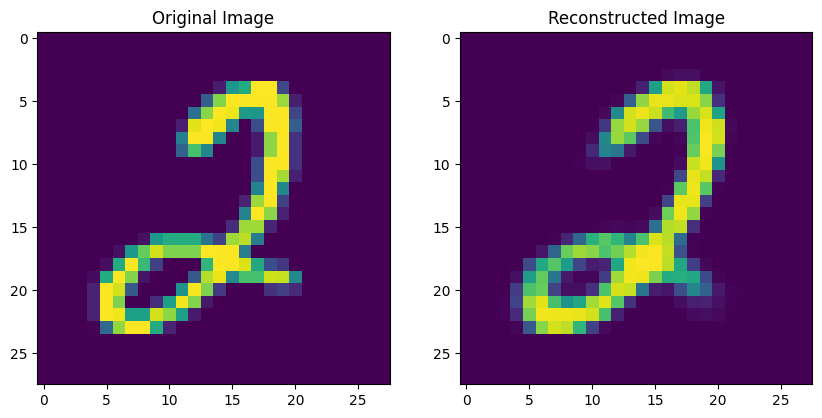

In [3]:
# Take a random sample from the training data
data, _ = next(iter(train_loader))
data = data.view(data.size(0), -1)  # Flatten the image

with torch.no_grad():
    recon_x, _, _ = model(data.to(device))

# Visualize the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(data.cpu().numpy()[0].reshape(28, 28))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(recon_x.cpu().numpy()[0].reshape(28, 28))
plt.title("Reconstructed Image")
plt.show()

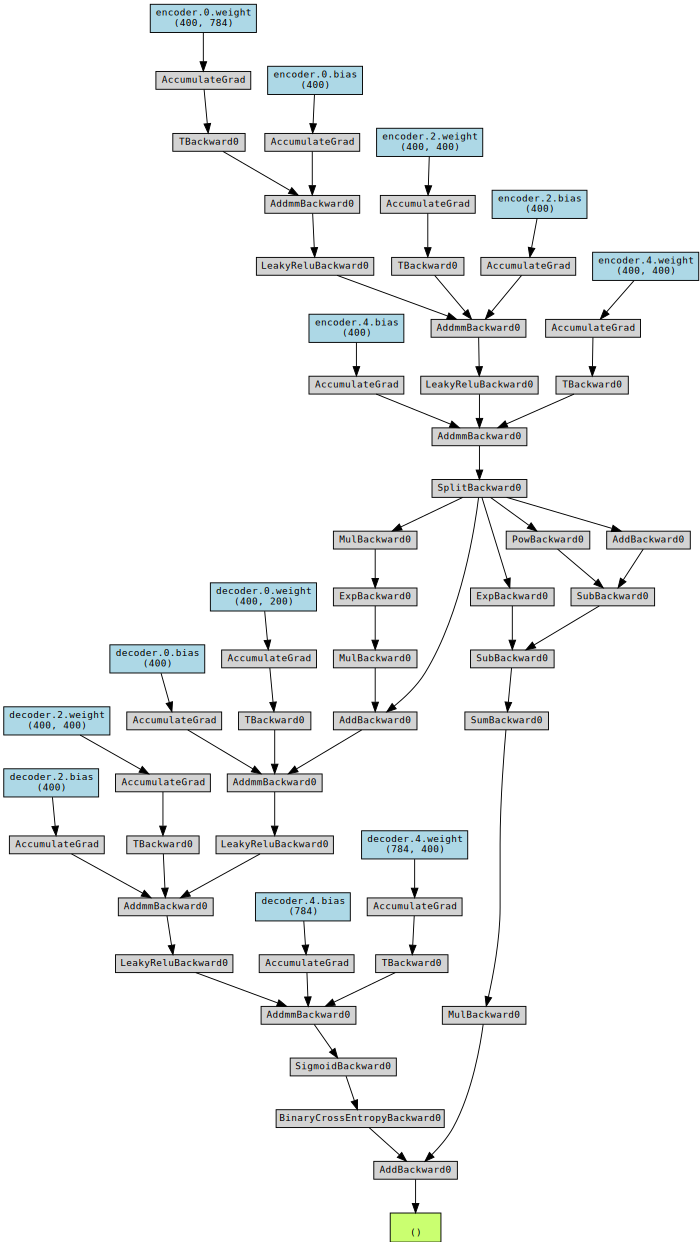

In [4]:
from torchviz import make_dot
make_dot(loss, params=dict(model.named_parameters()))

# Generate image from noise vector
Please note that this is not the correct generative process.

Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

In [5]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = model.decoder(noise)

In [6]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

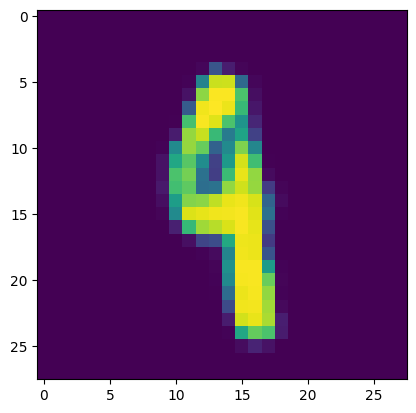

In [7]:
show_image(generated_images, idx=3)